
### In-Depth Explanation for Beginners

This code is all about teaching a computer to "write" new text, specifically in the style of the Irish lyrics it's trained on. It's a type of **sequence generation** using a **Recurrent Neural Network (RNN)**, specifically an **LSTM**.

Imagine you're trying to guess the next word in a sentence. You look at the words that came before it to make an educated guess. That's exactly what this model does\!

**1. The Goal: Next Word Prediction**

The core idea is to train a model that, given a sequence of words (e.g., "in the town of"), can predict the most likely *next word* (e.g., "athy"). By repeatedly predicting the next word and adding it to our growing sentence, we can generate entirely new text.

**2. The Data: Irish Lyrics**

  * We start with a plain text file containing Irish lyrics. This is our "knowledge base" or "corpus." The model will learn patterns from this text.
  * **Lowercase and Split:** We convert all text to lowercase (to treat "The" and "the" as the same word) and split it into individual lines.

**3. Preparing the Data for the Computer (Tokenization and N-grams)**

  * **Tokenizer (The "Word-to-Number Translator"):**
      * Computers only understand numbers. So, the first step is to convert all unique words in our lyrics into unique numbers.
      * `tokenizer.fit_on_texts(corpus)`: This is like the tokenizer creating its own dictionary. It goes through all the words in our lyrics and assigns `1` to the most frequent word, `2` to the second most frequent, and so on.
      * `total_words`: This tells us how many unique words (plus one for a special "padding" index, usually 0) are in our vocabulary.
  * **N-gram Sequences (The "Training Examples"):**
      * To teach the model to predict the next word, we need examples of "input sequence" -\> "next word."
      * For every line in the lyrics, we create many small "n-gram" sequences.
      * **Example:** If a line is "in the town of athy":
          * `[in]` -\> `the` (Our model learns: if you see `in`, `the` is a possible next word)
          * `[in, the]` -\> `town`
          * `[in, the, town]` -\> `of`
          * `[in, the, town, of]` -\> `athy`
      * `input_sequences`: This list will contain all these small sequences.
  * **Padding (Making them Uniform):**
      * Our neural network needs all input sequences to be the *same length*. Since our n-grams have different lengths (e.g., `[1]` vs. `[1, 2, 3, 4]`), we `pad_sequences`.
      * `padding='pre'`: We add zeros to the *beginning* of shorter sequences until they all match the `max_sequence_len` (the length of the longest n-gram).
      * Why 'pre' padding? For sequence models like LSTMs, padding at the beginning often helps preserve the context of the most recent words better.
  * **`xs` (Predictors) and `ys` (Labels):**
      * After padding, each sequence looks like `[0, 0, ..., word1, word2, word3, NEXT_WORD]`.
      * `xs`: We take all words *except* the `NEXT_WORD`. This is what the model will use as input to make a prediction.
      * `labels`: We take only the `NEXT_WORD`. This is the correct answer the model should try to predict.
  * **One-Hot Encoding (`ys = tf.keras.utils.to_categorical`):**
      * Our `labels` are still single numbers (e.g., `5` for "athy").
      * The final layer of our neural network will output probabilities for *every single word* in our vocabulary.
      * One-hot encoding converts a single number (like `5`) into a long list of zeros with a single `1` at the position corresponding to that number (e.g., `[0, 0, 0, 0, 0, 1, 0, ..., 0]`). This format matches the output of our `softmax` layer, making it easy for the model to learn.

**4. Building the "Brain" (The Neural Network Model)**

We're constructing a `Sequential` Keras model, meaning layers are stacked one on top of the other.

  * **`Embedding` Layer (The "Word Meaning" Layer):**

      * Just like in the sarcasm detector, this layer takes the integer word IDs (e.g., `5` for "athy") and converts them into dense, numerical vectors (100 numbers in this case).
      * The amazing thing is that the model *learns* these 100-number representations. Words with similar meanings or contexts will end up having similar vectors. This gives the model a richer understanding of words than just their unique ID.

  * **`Bidirectional(LSTM(150))` Layer (The "Memory" Layer):**

      * **LSTM (Long Short-Term Memory):** This is a special type of Recurrent Neural Network (RNN) layer designed to remember information over long sequences. Regular neural networks struggle with long-term dependencies (e.g., how a word at the beginning of a sentence influences a word at the end). LSTMs have internal "gates" that help them decide what information to remember and what to forget. This makes them excellent for text.
      * **`Bidirectional`:** This is key for context\! Instead of just processing the sequence from left-to-right (past context), a Bidirectional LSTM processes it *both* left-to-right and right-to-left (future context). The outputs from both directions are then combined. This means when the model predicts "athy," it not only considers "in the town of" but also, hypothetically, if the original corpus had patterns where "athy" was often followed by certain words. This gives the model a more complete understanding of the sequence.
      * `150`: This is the number of hidden units (or "memory cells") in each LSTM direction. More units mean more capacity to learn complex patterns.

  * **`Dense(total_words, activation='softmax')` Layer (The "Prediction" Layer):**

      * This is the output layer. It has one neuron for *every single word* in our vocabulary.
      * `softmax` activation: It takes the output from the LSTM and converts it into a probability distribution. The sum of all probabilities will be 1. The word with the highest probability is the model's prediction for the next word.

  * **`model.compile()`:**

      * `loss='categorical_crossentropy'`: This is the standard loss function for multi-class classification when your labels are one-hot encoded. The model tries to minimize this value during training.
      * `optimizer=Adam(learning_rate=0.01)`: `Adam` is the algorithm that adjusts the model's internal settings (weights) to minimize the loss. `learning_rate` controls how big these adjustments are.
      * `metrics=['accuracy']`: During training, we want to see how often the model correctly predicts the next word.

**5. Training the Model (The "Learning" Process)**

  * `history = model.fit(xs, ys, epochs=100, verbose=1)`: This is where the model learns.
      * It takes `xs` (the input sequences) and `ys` (the correct next words, one-hot encoded).
      * It goes through the entire training data 100 times (`epochs=100`).
      * In each epoch, for every input sequence, the model:
        1.  Makes a prediction for the next word.
        2.  Compares its prediction to the actual next word (`ys`).
        3.  Calculates the "error" (loss).
        4.  Adjusts its internal weights using the `Adam` optimizer to reduce that error in the future.
      * `verbose=1` means you'll see a progress bar and accuracy/loss updates during training. This can take some time\!

**6. Evaluating Training Progress (Checking "Learning Curves")**

  * `plot_graphs(history, 'accuracy')`: This function helps visualize how the model's `accuracy` changed over the 100 `epochs`. You want to see the accuracy generally increasing, indicating that the model is learning to predict the next word better over time.

**7. Generating New Text (Putting the "Knowledge" to Use)**

  * `seed_text`: We start with a short phrase (e.g., "I've got a bad feeling about this").
  * `next_words`: We decide how many words we want the model to generate (e.g., 100 words).
  * **The Loop:**
    1.  **Prepare Input:** The `seed_text` is converted into numbers and padded to the correct `input_length` required by the model.
    2.  **Predict:** `model.predict(token_list)` makes the model guess the next word based on the current `seed_text`. It outputs a probability distribution over all possible words.
    3.  **Choose Best Word:** `np.argmax()` finds the word with the highest predicted probability.
    4.  **Convert Back to Word:** We use `tokenizer.index_word` (the reverse of `word_index`) to convert the predicted number back into an actual word.
    5.  **Append:** The newly predicted word is added to the `seed_text`.
    6.  **Repeat:** The loop continues, using the expanded `seed_text` as the new input for the next prediction, effectively building a sentence word by word.

This iterative process allows the model, having learned patterns and relationships between words from the Irish lyrics, to "compose" new text that (hopefully) sounds somewhat similar in style or vocabulary to its training data.

## This code builds a character-level text generation model using Keras and TensorFlow. It learns to predict the next word in a sequence based on the preceding words, effectively writing new text in the style of the input corpus.

In [12]:
# Cell 1: Imports and Setup

import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt # Import matplotlib for plotting history
import io # Import io for file operations (if saving embeddings, though not directly in this code)

# Note: The %tensorflow_version magic command is specific to Google Colab.
# If you are running this in a local Jupyter Notebook or VS Code,
# you can comment out or remove the try-except block below,
# provided you have TensorFlow 2.x already installed in your environment.
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

In [19]:
# Cell 2: Download Data

# Define the local file path and download URL
local_file_path = "irish-lyrics-eof.txt"
download_url = "https://storage.googleapis.com/learning-datasets/irish-lyrics-eof.txt"

# Use Python's urllib.request for platform-independent downloading
import urllib.request
import os # Import os for path operations if needed, though not strictly here

print(f"Downloading {download_url} to {local_file_path}...")
try:
    urllib.request.urlretrieve(download_url, local_file_path)
    print("Download complete!")
except Exception as e:
    print(f"Error downloading file: {e}")
    # You might want to exit or raise an error here if download is critical
    raise # Re-raise the exception to stop execution if download failed

# The previous !wget command (if on Windows, it might not work as expected)
# !wget --no-check-certificate \
#     https://storage.googleapis.com/learning-datasets/irish-lyrics-eof.txt \
#     -O /tmp/irish-lyrics-eof.txt

Download complete!


In [20]:
# Cell 3: Load and Prepare Text Data

tokenizer = Tokenizer() # Initialize the Tokenizer

# Open the downloaded file (ensure it's in the correct path or current directory)
data = open(local_file_path).read() # Read the entire content of the file

corpus = data.lower().split("\n") # Convert all text to lowercase and split it into individual lines (sentences)

tokenizer.fit_on_texts(corpus) # Builds the vocabulary from the corpus. It assigns a unique integer to each unique word.
total_words = len(tokenizer.word_index) + 1 # Calculate the total number of unique words + 1 (for padding/0 index)

print("Word Index (first 20 entries):")
# Prints the mapping from words to their integer indices.
# We'll print only a few to avoid overwhelming output.
for i, (word, index) in enumerate(tokenizer.word_index.items()):
    if i < 20:
        print(f"'{word}': {index}")
    else:
        break
print(f"Total unique words in vocabulary (including 0 for padding): {total_words}")

Word Index (first 20 entries):
'the': 1
'and': 2
'i': 3
'to': 4
'a': 5
'of': 6
'my': 7
'in': 8
'me': 9
'for': 10
'you': 11
'all': 12
'was': 13
'she': 14
'that': 15
'on': 16
'with': 17
'her': 18
'but': 19
'as': 20
Total unique words in vocabulary (including 0 for padding): 2690


In [21]:
# Cell 4: Create N-gram Sequences

input_sequences = [] # Initialize an empty list to store all the n-gram sequences

# Iterate through each line (sentence) in the corpus
for line in corpus:
    token_list = tokenizer.texts_to_sequences([line])[0] # Convert the current line into a sequence of integer tokens
    # Example: "in the town" -> [1, 2, 3]

    # Generate n-grams for the current token_list
    for i in range(1, len(token_list)): # Loop from the second token to the end of the list
        n_gram_sequence = token_list[:i+1] # Create a sub-sequence from the beginning up to the current token
        input_sequences.append(n_gram_sequence) # Add this n-gram sequence to our list

print(f"Total number of n-gram sequences generated: {len(input_sequences)}")
print("First 5 n-gram sequences:")
for seq in input_sequences[:5]:
    print(seq)

Total number of n-gram sequences generated: 12038
First 5 n-gram sequences:
[51, 12]
[51, 12, 96]
[51, 12, 96, 1217]
[51, 12, 96, 1217, 48]
[51, 12, 96, 1217, 48, 2]


In [22]:
# Cell 5: Pad Sequences and Create Predictors/Labels

# Find the maximum length among all generated n-gram sequences
max_sequence_len = max([len(x) for x in input_sequences])
print(f"Maximum sequence length: {max_sequence_len}")

# Pad all sequences to the same length by adding zeros at the beginning ('pre')
# This is crucial because neural networks require fixed-size inputs.
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))
print(f"Shape of padded input sequences: {input_sequences.shape}")

# Create predictors (xs) and labels (ys)
# xs: All tokens except the last one in each sequence. These are the input words for prediction.
xs = input_sequences[:,:-1]
# labels: The last token in each sequence. This is the word the model should predict.
labels = input_sequences[:,-1]

# Convert labels to one-hot encoding
# One-hot encoding is necessary for multi-class classification with 'softmax' output layer.
# 'num_classes' must be the total_words (vocabulary size).
ys = tf.keras.utils.to_categorical(labels, num_classes=total_words)

print(f"\nShape of xs (predictors): {xs.shape}")
print(f"Shape of ys (one-hot encoded labels): {ys.shape}")

# Example prints for understanding
print("\nWord indices for specific words:")
print(f"'in': {tokenizer.word_index['in']}")
print(f"'the': {tokenizer.word_index['the']}")
print(f"'town': {tokenizer.word_index['town']}")
print(f"'of': {tokenizer.word_index['of']}")
print(f"'athy': {tokenizer.word_index['athy']}")
print(f"'one': {tokenizer.word_index['one']}")
print(f"'jeremy': {tokenizer.word_index['jeremy']}")
print(f"'lanigan': {tokenizer.word_index['lanigan']}")

print(f"\nExample xs[6] (input sequence): {xs[6]}")
print(f"Example ys[6] (one-hot encoded label for xs[6]): {ys[6]}") # This will be a long array of zeros with one '1'
print(f"The actual label for xs[6] is word index: {labels[6]}")
print(f"Word corresponding to label {labels[6]}: {tokenizer.index_word[labels[6]]}") # index_word is the reverse mapping

print(f"\nExample xs[5] (input sequence): {xs[5]}")
print(f"Example ys[5] (one-hot encoded label for xs[5]): {ys[5]}")
print(f"The actual label for xs[5] is word index: {labels[5]}")
print(f"Word corresponding to label {labels[5]}: {tokenizer.index_word[labels[5]]}")

Maximum sequence length: 16
Shape of padded input sequences: (12038, 16)

Shape of xs (predictors): (12038, 15)
Shape of ys (one-hot encoded labels): (12038, 2690)

Word indices for specific words:
'in': 8
'the': 1
'town': 71
'of': 6
'athy': 713
'one': 39
'jeremy': 1790
'lanigan': 1791

Example xs[6] (input sequence): [0 0 0 0 0 0 0 0 0 0 0 0 0 0 2]
Example ys[6] (one-hot encoded label for xs[6]): [0. 0. 0. ... 0. 0. 0.]
The actual label for xs[6] is word index: 11
Word corresponding to label 11: you

Example xs[5] (input sequence): [   0    0    0    0    0    0    0    0    0   51   12   96 1217   48
    2]
Example ys[5] (one-hot encoded label for xs[5]): [0. 0. 0. ... 0. 0. 0.]
The actual label for xs[5] is word index: 69
Word corresponding to label 69: fair


In [ ]:
# Cell 6: Build the Model

model = Sequential() # Initialize a sequential model (layers stacked linearly)

# Embedding Layer:
# total_words: Size of the vocabulary (number of unique words).
# 100: Dimension of the dense embedding for each word. Each word will be represented by a 100-dimensional vector.
# input_length: The length of the input sequences (max_sequence_len - 1 because we use the last word as the label).
model.add(Embedding(total_words, 100, input_length=max_sequence_len-1))

# Bidirectional LSTM Layer:
# LSTM (Long Short-Term Memory) is a type of recurrent neural network (RNN) good for sequence data.
# Bidirectional wraps an LSTM layer, allowing it to process the sequence in both forward and backward directions.
# This helps the model capture context from both past and future words.
# 150: Number of units (neurons) in the LSTM layer.
model.add(Bidirectional(LSTM(150)))

# Dense Output Layer:
# total_words: Number of neurons in the output layer, equal to the vocabulary size.
# softmax: Activation function that converts raw scores into probabilities.
# The output is a probability distribution over all words in the vocabulary,
# indicating the likelihood of each word being the next word in the sequence.
model.add(Dense(total_words, activation='softmax'))

# Compile the model:
# Adam: An optimization algorithm used to adjust the model's weights during training.
# lr=0.01: Learning rate for the Adam optimizer.
adam = Adam(learning_rate=0.01) # Use learning_rate instead of lr for newer TensorFlow versions
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

model.summary() # Print a summary of the model architecture

c:\Users\AsadMunir\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Cell 7: Train the Model

epochs = 100 # Number of times the model will iterate over the entire training dataset

# Train the model
# xs: Input sequences (predictors)
# ys: One-hot encoded labels (the next word to predict)
# epochs: Number of training iterations
# verbose=1: Show progress bar during training
history = model.fit(xs, ys, epochs=epochs, verbose=1)

# print(model) # This line just prints the model object, not very informative.
# model.summary() (already called in previous cell) is more useful.

Epoch 1/100
377/377 ━━━━━━━━━━━━━━━━━━━━ 20s 38ms/step - accuracy: 0.0662 - loss: 6.8020
Epoch 2/100
377/377 ━━━━━━━━━━━━━━━━━━━━ 13s 35ms/step - accuracy: 0.1067 - loss: 5.7449
Epoch 3/100
377/377 ━━━━━━━━━━━━━━━━━━━━ 14s 36ms/step - accuracy: 0.1617 - loss: 4.8040
Epoch 4/100
377/377 ━━━━━━━━━━━━━━━━━━━━ 16s 43ms/step - accuracy: 0.2537 - loss: 3.8554
Epoch 5/100
377/377 ━━━━━━━━━━━━━━━━━━━━ 16s 42ms/step - accuracy: 0.2996 - loss: 3.5142
Epoch 6/100
377/377 ━━━━━━━━━━━━━━━━━━━━ 16s 42ms/step - accuracy: 0.4428 - loss: 2.5221
Epoch 7/100
377/377 ━━━━━━━━━━━━━━━━━━━━ 13s 35ms/step - accuracy: 0.5474 - loss: 1.9463
Epoch 8/100
377/377 ━━━━━━━━━━━━━━━━━━━━ 15s 39ms/step - accuracy: 0.6186 - loss: 1.6152
Epoch 9/100
377/377 ━━━━━━━━━━━━━━━━━━━━ 15s 38ms/step - accuracy: 0.6759 - loss: 1.3548
Epoch 10/100
377/377 ━━━━━━━━━━━━━━━━━━━━ 15s 41ms/step - accuracy: 0.7198 - loss: 1.1615
Epoch 11/100
377/377 ━━━━━━━━━━━━━━━━━━━━ 19s 49ms/step - accuracy: 0.7526 - loss: 1.0520
Epoch 12/100
377/37

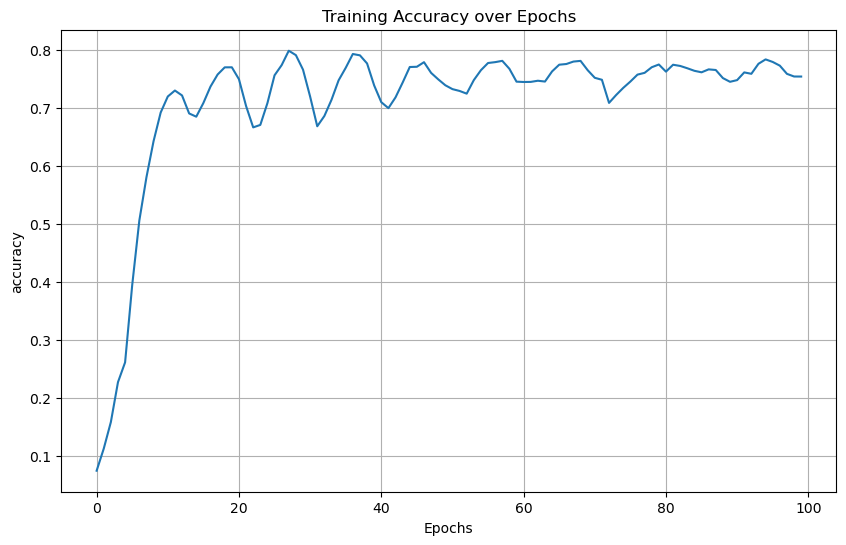

In [ ]:
# Cell 8: Plot Training Accuracy

def plot_graphs(history, string):
  plt.figure(figsize=(10, 6)) # Make figure a bit larger
  plt.plot(history.history[string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.title(f'Training {string.capitalize()} over Epochs')
  plt.grid(True) # Add grid for better readability
  plt.show()

plot_graphs(history, 'accuracy') # Plot the training accuracy

In [ ]:
# Cell 9: Generate Text

seed_text = "I've got a bad feeling about this" # The starting text for generation
next_words = 100 # Number of words to generate

print(f"Starting text generation with seed: '{seed_text}'\n")

# Loop to generate 'next_words' number of words
for _ in range(next_words):
    # Convert the current seed_text into a sequence of tokens
    token_list = tokenizer.texts_to_sequences([seed_text])[0]

    # Pad the token_list to match the input length expected by the model (max_sequence_len-1)
    # This is crucial for consistent input shape.
    token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')

    # Predict the probabilities for the next word
    # model.predict returns a 2D array, where each row is a probability distribution.
    # np.argmax with axis=-1 finds the index of the highest probability in the last dimension.
    predicted_index = np.argmax(model.predict(token_list, verbose=0), axis=-1)[0] # verbose=0 suppresses prediction output

    output_word = "" # Initialize an empty string for the predicted word

    # Iterate through the word_index to find the word corresponding to the predicted index
    # Note: tokenizer.index_word is a more direct way to do this if available (it often is after fit_on_texts)
    # The original code's loop is a bit less efficient than using tokenizer.index_word directly.
    # Let's use tokenizer.index_word if it exists for efficiency.
    if hasattr(tokenizer, 'index_word'):
        output_word = tokenizer.index_word.get(predicted_index, "?") # Use .get for unknown indices
    else: # Fallback if index_word is not directly available (less common for recent Keras)
        for word, index in tokenizer.word_index.items():
            if index == predicted_index:
                output_word = word
                break

    # If the word is still not found (e.g., predicted_index was 0 which is padding), handle it
    if output_word == "":
        output_word = "?" # Assign a placeholder if no word is found for the index

    # Append the predicted word to the seed_text for the next iteration
    seed_text += " " + output_word

print(seed_text) # Print the final generated text

Starting text generation with seed: 'I've got a bad feeling about this'

I've got a bad feeling about this high for more day that hed will be found gallant irishmen to greet gone corporal clothes fall wid the call as any star wall by the sun over moon wid you eyes gone alas is the love light gone by aisey water me heavens bright heavens sun is say him me lads and late from comes me bond dressed rings them them them now gone by them all your toes him a moment saw across crystal drawn oer oer the table weeping brown englishmen spancil hill for lanigans ball or gown more bravely gone what thousand cross love leave it
